# Data Import

In [1]:
from data_mining2 import data
d=data()

11it [00:13,  1.19s/it]


In [2]:
dataset=d.merge_whole_dataset()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 53.03it/s]


In [3]:
import datetime
dataset['Date_datetime'] = dataset['Date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from datetime import timedelta
import math
from matplotlib import dates
import plotly.graph_objects as go


%matplotlib inline

# Plot Def

In [5]:
def TrendPlot(exp,inf,rec,train_data, y_pred):
    
        f = plt.figure(figsize=(16,5))
        ax = f.add_subplot(1,2,1)
        ax.plot(exp, 'y', label='Exposed');
        ax.plot(inf, 'r', label='Infected');
        ax.plot(rec, 'c', label='Recovered/deceased');
        plt.title('SEIR Model Trends')
        plt.xlabel("Days", fontsize=10);
        plt.ylabel("Fraction of population", fontsize=10);
        plt.legend(loc='best');
        
        #train_date_remove_year = train_data['Date_datetime'].apply(lambda date:'{:%m-%d}'.format(date))
        ax2 = f.add_subplot(1,2,2)
        xaxis = train_data['Date_datetime'].tolist()
        xaxis = dates.date2num(xaxis)
        hfmt = dates.DateFormatter('%m\n%d')
        ax2.xaxis.set_major_formatter(hfmt)
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'),train_data['ConfirmedCases'],label='Confirmed Cases (train)', c='g')
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'), y_pred['ConfirmedCases'][:len(train_data)],label='Cumulative modeled infections', c='r')
        plt.title('Real ConfirmedCase and Predict ConfirmedCase')
        plt.legend(loc='best');
        plt.show()
        return "Drawn"

In [6]:
def LongTermPlot(time_array, y_pred, train_data, where_time_con, max_con, where_time, pred_max_day
                 , start, end, train_max, area_name, population):

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=time_array, y=y_pred['ConfirmedCases'].astype(int),
                            mode='lines',
                            line = dict(color='red'),
                            name='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date())))
        fig.add_trace(go.Scatter(x=time_array[:len(train_data)], y=train_data['ConfirmedCases'],
                            mode='lines',
                            name='Confirmed case until '+ str(train_max.date()),line = dict(color='green', width=4)))
        fig.add_annotation(
            x=where_time_con,
            y=max_con-(max_con/30),
            showarrow=False,
            text="Estimate Max Case around:" +str(int(max_con)),
            font=dict(
                color="Blue",
                size=15
            ))
        fig.add_annotation(
            x=time_array[len(train_data)-1],
            y=train_data['ConfirmedCases'].tolist()[-1],
            showarrow=True,
            text=f"Real Max ConfirmedCase: " +str(int(train_data['ConfirmedCases'].tolist()[-1]))) 
        
        fig.add_annotation(
            x=where_time,
            y=pred_max_day,
            text='Infect start decrease from: ' + str(where_time))   
        fig.update_layout(title='Estimate Confirmed Case ,'+area_name+' Total population ='+ str(int(population)), legend_orientation="h")
        fig.show()
        return "Drawn"

# SEIR Equations

In [27]:
# Function code refernece from https://www.kaggle.com/anjum48/seir-model-with-intervention

# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
        
    S, E, I, R = y
    
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    
    return [S_out, E_out, I_out, R_out]

In [28]:
## to even fluctuations

def cumsum_signal(vec):
    temp_val = 0
    vec_new = []
    for i in vec:
        if i > temp_val:
            vec_new.append(i)
            temp_val = i
        else:
            vec_new.append(temp_val)
    return vec_new

# Fitting the model to the data

In [66]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    #R_0, cfr = params # Paramaters, R0 and cfr 
    R_0,x = params
    cfr = 0.01
    #R_0, x = params
#     x = x
    N = population # Population of each country
    n_infected = data['ConfirmedCases'].iloc[0] # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days # How many days want to predict
    s, e, i, r = (N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
    
 #  def time_varying_reproduction(t):
 #      if t > 80: # we set intervention days = 80
 #          return R_0 * 0.5
 #      else:
 #          return R_0    
    
    # R0 is time dependent on the Stringency Index
    def time_varying_reproduction(t):
        if (t<len(data)):
            if(math.isnan(data["StringencyIndex"].iloc[int(t)]) == False):
                temp = R_0 *(x/data["StringencyIndex"].iloc[int(t)])
            else:
                temp = R_0 *(x/80)
        else: 
            temp = R_0 *(x/80)
      #print (temp)
        return temp
    
#   def time_varying_reproduction(t):
#       if (t<len(data)):
#           if(math.isnan(data["StringencyIndex"].iloc[int(t)]) == False):
#               temp = R_0 -(x/14) * data["StringencyIndex"].iloc[int(t)]
#           else:
#               temp = R_0 -(x/14) * 71
#       else: 
#           temp = R_0 -(x/14) * 71
#       #print (temp)
#       return temp
   
   
    sol = solve_ivp(fun=lambda t,y:SEIR_model(t, y, time_varying_reproduction, T_inf, T_inc),
                    t_span=[0, max_days],y0=[s, e, i, r], t_eval=np.arange(max_days))
    
    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
    y_true_cases = data['ConfirmedCases'].values
    
    # Predict Fatalities by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    #msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    #msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
    #    return msle_final, sol
        return msle_cases, sol
    else:
    #    return msle_final
        return msle_cases

In [67]:
def fit_model_new(data, area_name, initial_guess=[2.2, 0.02, 2, 50], 
              bounds=((1, 20), (0, 0.15), (1, 3), (1, 100)), make_plot=True):
    cfr = 0.01
    
    train_data = data.query('ConfirmedCases > 0').copy()
        
    ####### If this country have no ConfirmedCase, return 0 #######
    if len(train_data) == 0:
        result_zero = np.zeros((43))
        return pd.DataFrame({'ConfirmedCases':result_zero,'Fatalities':result_zero}), 0 
    
    population = train_data["Pop"].iloc[0]
    n_infected = train_data['ConfirmedCases'].iloc[0]
         
    ####### Fit the real data by minimizing the MSLE #######
    #res_const = minimize(eval_model_const, [5, 48], bounds=((1, 40), (0, 100)),
    #                     args=(train_data, population, False),
    #                     method='L-BFGS-B')
    res_const = minimize(eval_model_const, [5,48], bounds=((0,20),(0,100)), 
                        args=(train_data, population, False),
                         method='SLSQP')
    #res_const = minimize(eval_model_const, [2.2, 48], bounds=((1, 20), (0, 100)),
    #                     args=(train_data, population, False),
    #                     method='L-BFGS-B')
    
    print(res_const)
    
    ####### Align the date information #######
    test_end = datetime.datetime.strptime('2020-04-30','%Y-%m-%d')
    test_start = datetime.datetime.strptime('2020-03-12','%Y-%m-%d')
    train_max = train_data.Date_datetime.max()
    train_min = train_data.Date_datetime.min()
    add_date = 0
    delta_days =(test_end - train_max).days
    train_add_time=[]

    if train_min > test_start:
        add_date = (train_min-test_start).days
        last = train_min-timedelta(add_date)
        train_add_time = np.arange(last, train_min, dtype='datetime64[D]').tolist()
        train_add_time = pd.to_datetime(train_add_time)
        dates_all = train_add_time.append(pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]')))
    else:
        dates_all = pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]'))


    msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
    
    res = res_const

    ####### Predict the result by using best fit paramater of SEIR model ####### 
    sus, exp, inf, rec = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': cumsum_signal((np.clip((inf + rec) * population,0,np.inf)).tolist()),
       # 'ConfirmedCases': [inf[0]*population for i in range(add_date)]+(np.clip((inf + rec) * population,0,np.inf)).tolist(),
       # 'Fatalities': [rec[0]*population for i in range(add_date)]+(np.clip(rec, 0, np.inf) * population * res.x[1]).tolist()
        #'Fatalities': cumsum_signal((np.clip(rec * population * res.x[1], 0, np.inf)).tolist())
        'Fatalities': cumsum_signal((np.clip(rec * population * cfr, 0, np.inf)).tolist())
    })
    
    y_pred_valid = y_pred.iloc[:len(train_data)]
    y_pred_test = y_pred.iloc[-43:]
    y_true_valid = train_data[['ConfirmedCases', 'Fatalities']]
    
    ####### Calculate MSLE ####### 
    valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    ####### Plot the fit result of train data and forecast after 300 days ####### 
    if make_plot:
        #print(f'Validation MSLE: {valid_msle:0.5f}, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}')
        ####### Plot the fit result of train data dna SEIR model trends #######
#         print("x")
#         print(res.x[0])
        TrendPlot(exp,inf,rec,train_data, y_pred)
            
   #    ####### Forecast 300 days after by using the best paramater of train data #######
   #    if len(res.x)>2:
   #        msle, sol = eval_model_decay(res.x, train_data, population, True, 300)
   #    else:
   #        msle, sol = eval_model_const(res.x, train_data, population, True, 300)
   #    
   #    sus, exp, inf, rec = sol.y
   #    
   #    y_pred = pd.DataFrame({
   #        'ConfirmedCases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
   #        'Fatalities': cumsum_signal(np.clip(rec, 0, np.inf) * population * res.x[1])
   #    })
   #    
   #    ####### Plot 300 days after of each country #######
   #    start = train_min
   #    end = start + timedelta(len(y_pred))
   #    time_array = np.arange(start, end, dtype='datetime64[D]')

   #    max_day = np.where(inf == np.amax(inf))[0][0]
   #    where_time = time_array[max_day]
   #    pred_max_day = y_pred['ConfirmedCases'][max_day]
   #    xy_show_max_estimation = (where_time, max_day)
   #    
   #    con = y_pred['ConfirmedCases']
   #    max_day_con = np.where(con == np.amax(con))[0][0] # Find the max confimed case of each country
   #    max_con = np.amax(con)
   #    where_time_con = time_array[len(time_array)-50]
   #    xy_show_max_estimation_confirmed = (where_time_con, max_con)
   #    
   #    LongTermPlot(time_array, y_pred, train_data, where_time_con, max_con, where_time, pred_max_day
   #                  , start, end, train_max, area_name, population)
        
    return y_pred_test, valid_msle

# Running it with a sample country

     fun: 0.7862078353031715
     jac: array([0.31545821, 0.00860087])
 message: 'Optimization terminated successfully.'
    nfev: 156
     nit: 24
    njev: 23
  status: 0
 success: True
       x: array([ 1.13489331, 41.62343636])


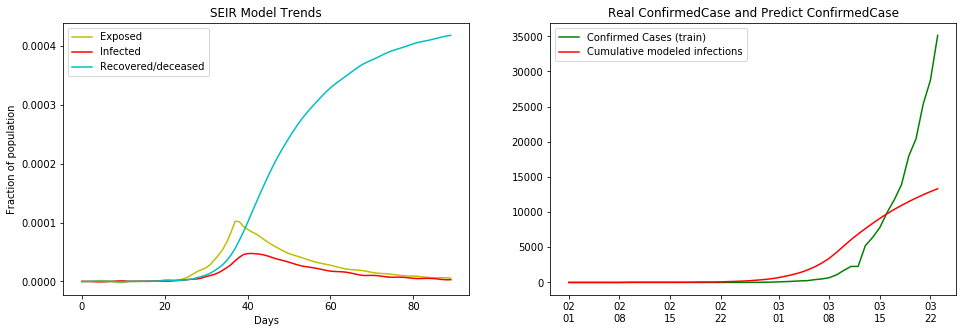

In [73]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention

country = 'Spain'

if country not in dataset['Country_Region'].unique():
    country_pd_train = dataset[dataset['Province_State']==country]
else:
    country_pd_train = dataset[dataset['Country_Region']==country]

country_pd_train = country_pd_train[:-3]
    
a,b = fit_model_new(country_pd_train,country,make_plot=True)

In [ ]:
country_pd_train.head(70)